# Inference with COSDD

In this notebook, we will use the model trained in the previous step to denoise the data.

In [1]:
import os
import logging

import tifffile
import torch
import pytorch_lightning as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as PSNR

import utils
from dvlae import DVLAE

logger = logging.getLogger('pytorch_lightning')
logger.setLevel(logging.WARNING)
%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()

## 1. Load test data
The images that we want to denoise are loaded here. Since high signal-to-noise ratio reference images are available for this dataset, we'll load those too.<br>
For the Actin-Confocal dataset, we follow original authors and use the last 8 images as a test set.

In [3]:
low_snr_path = "data/mito-confocal-lowsnr.tif"
high_snr_path = "data/mito-confocal-highsnr.tif"

low_snr = tifffile.imread(low_snr_path)[-8:, None]
low_snr = torch.from_numpy(low_snr.astype(float)).to(torch.float)
high_snr = tifffile.imread(high_snr_path)[-8:, None]
print(low_snr.shape)

# The high snr reference images for this dataset are on a different scale to the low snr images.
# We will scale and shift the reference images to match the noisy images.
high_snr = utils.minimise_mse(high_snr, low_snr.numpy())

torch.Size([8, 1, 1024, 1024])


As with training, data should be a `torch.Tensor` with dimensions: [Number of images, Channels, Height, Width] with data type float32.

## 2. Create prediction dataloader

`predict_batch_size` Number of denoised images to produce at a time.

In [4]:
predict_batch_size = 1

predict_set = utils.PredictDataset(low_snr)
predict_loader = torch.utils.data.DataLoader(
    predict_set,
    batch_size=predict_batch_size,
    shuffle=False,
    pin_memory=True,
)

## 3. Load trained model

In [5]:
model_name = "mito-confocal"
checkpoint_path = os.path.join("checkpoints", model_name)

dvlae = DVLAE.load_from_checkpoint(os.path.join(checkpoint_path, "final_model.ckpt"))

trainer = pl.Trainer(
    accelerator="gpu" if use_cuda else "cpu",
    devices=1,
    enable_progress_bar=False,
)

/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'vae' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vae'])`.
/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'ar_decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['ar_decoder'])`.
/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 's_decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['s_decoder'])`.
/home/ben/miniforge3/envs/autonoise/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'direct_d

## 4. Denoise
In this section, we will look at how COSDD does inference. <br>

The model denoises images randomly, giving us a different output each time. First, we will compare two randomly sampled denoised images for the same noisy image. Then, we will produce a single consensus estimate by averaging 100 randomly sampled denoised images. Finally, if the direct denoiser was trained in the previous step, we will see how it can be used to estimate this average in a single pass.

### 4.1 Random sampling 
First, we will denoise each image six times and look at the difference between each estimate. The output of the model is stored in the `samples` variable. This has dimensions [Number of images, Sample index, Channels, Height, Width] where different denoised samples for the same image are stored along sample index.

In [6]:
use_direct_denoiser = False
n_samples = 6

dvlae.direct_pred = use_direct_denoiser

samples = []
for _ in tqdm(range(n_samples)):
    out = trainer.predict(dvlae, predict_loader)
    out = torch.cat(out, dim=0)
    samples.append(out)

samples = torch.stack(samples, dim=1)

100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Viewing the results. Change `img_idx` to look at a different image and change `crop` to view a different section.

In [7]:
vmin = np.percentile(low_snr.numpy(), 1)
vmax = np.percentile(low_snr.numpy(), 99)

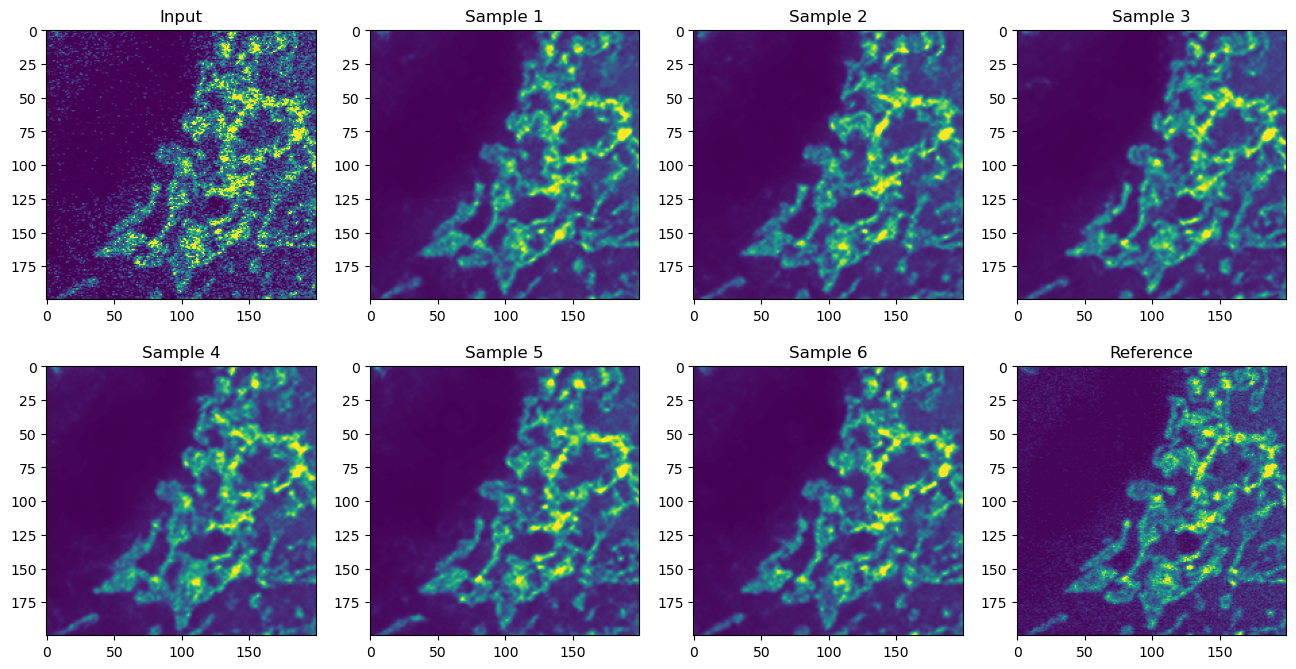

In [8]:
img_idx = 0
crop = (0, slice(500, 700), slice(600, 800))

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0, 0].imshow(low_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[0, 0].set_title("Input")
for i in range(n_samples):
    ax[(i+1)//4, (i+1)%4].imshow(samples[img_idx][i][crop], vmin=vmin, vmax=vmax)
    ax[(i+1)//4, (i+1)%4].set_title(f"Sample {i+1}")
ax[1, 3].imshow(high_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[1, 3].set_title("Reference")

plt.show()

The two sampled denoised images have subtle differences that express the uncertainty involved in this denoising problem. We can use the reference high snr data to compare their PSNR.

In [9]:
for i in range(2):
    psnrs = []
    for j in range(len(low_snr)):
        gt = high_snr[j].squeeze()
        test = samples[j, i].numpy().squeeze()

        data_range = np.max(gt) - np.min(gt)

        psnrs.append(PSNR(gt, test, data_range=data_range.item()))

    print(f"PSNR sample {i}: {np.mean(psnrs)}")

PSNR sample 0: 28.586976095262493
PSNR sample 1: 28.608874070633824


### 4.2 MMSE estimate

In the next cell, we sample 100 denoised images and average them for the minimum mean square estimate (MMSE). The averaged images will be stored in the `MMSEs` variable, which has the same dimensions as `low_snr`. Change `n_samples` to average a different number of images.

In [10]:
use_direct_denoiser = False
n_samples = 100

dvlae.direct_pred = use_direct_denoiser

samples = []
for _ in tqdm(range(n_samples)):
    out = trainer.predict(dvlae, predict_loader)
    out = torch.cat(out, dim=0)
    samples.append(out)

samples = torch.stack(samples, dim=1)
MMSEs = torch.mean(samples, dim=1)

100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


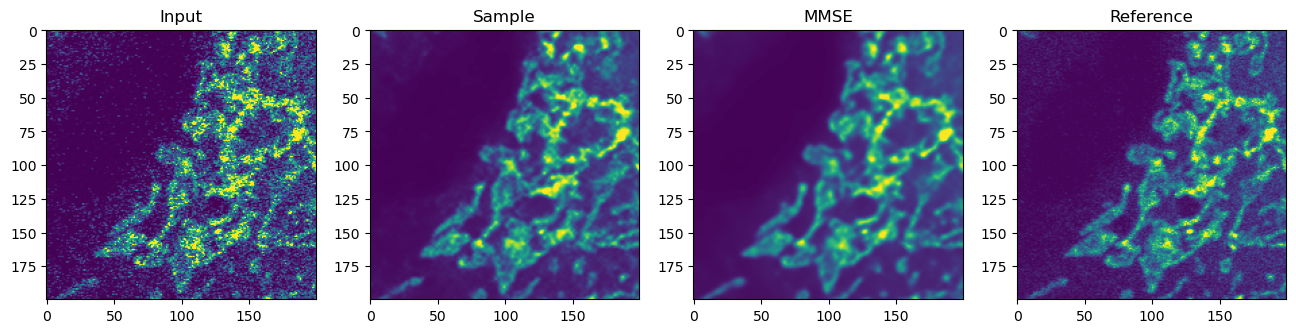

In [11]:
img_idx = 0
crop = (0, slice(500, 700), slice(600, 800))

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(low_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[0].set_title("Input")
ax[1].imshow(samples[img_idx][0][crop], vmin=vmin, vmax=vmax)
ax[1].set_title("Sample")
ax[2].imshow(MMSEs[img_idx][crop], vmin=vmin, vmax=vmax)
ax[2].set_title("MMSE")
ax[3].imshow(high_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[3].set_title("Reference")

plt.show()

The MMSE will usuallty be closer to the reference than an individual sample and would score a higher PSNR, although it will also be blurrier.

In [12]:
psnrs = []
for j in range(len(low_snr)):
    gt = high_snr[j].squeeze()
    test = MMSEs[j].numpy().squeeze()

    data_range = np.max(gt) - np.min(gt)

    psnrs.append(PSNR(gt, test, data_range=data_range.item()))

print(f"PSNR MMSE: {np.mean(psnrs)}")

PSNR MMSE: 30.253165280231414


### 4.3 Direct denoising
Sampling 100 images and averaging them is a very time consuming. If the direct denoiser was trained in a previous step, it can be used to directly output what the average denoised image would be for a given noisy image.

In [13]:
use_direct_denoiser = True
dvlae.direct_pred = use_direct_denoiser

direct = trainer.predict(dvlae, predict_loader)
direct = torch.cat(direct, dim=0)

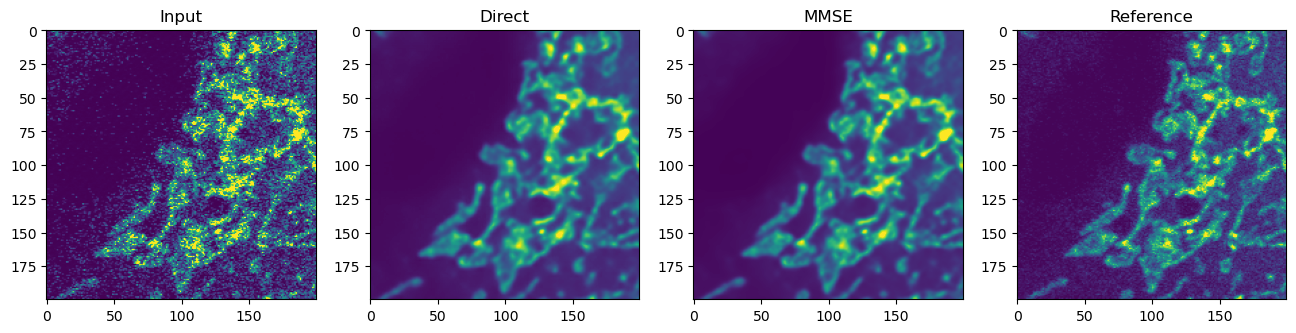

In [14]:
img_idx = 0
crop = (0, slice(500, 700), slice(600, 800))

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(low_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[0].set_title("Input")
ax[1].imshow(direct[img_idx][crop], vmin=vmin, vmax=vmax)
ax[1].set_title("Direct")
ax[2].imshow(MMSEs[img_idx][crop], vmin=vmin, vmax=vmax)
ax[2].set_title("MMSE")
ax[3].imshow(high_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[3].set_title("Reference")

plt.show()

The PSNR of the direct estimate is often higher than the PSNR of the average of 100 samples.

In [15]:
psnrs = []
for j in range(len(low_snr)):
    gt = high_snr[j].squeeze()
    test = direct[j].numpy().squeeze()

    data_range = np.max(gt) - np.min(gt)

    psnrs.append(PSNR(gt, test, data_range=data_range.item()))

print(f"PSNR direct: {np.mean(psnrs)}")


PSNR direct: 30.265619464044896
